In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision timm transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 711.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from typing import Tuple
import random
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Data loader class that applies data augmentation, change to grayscale and normalize all images in the dataset 1
class CovidDataloader:
    def __init__(self):
        dataset = "Pre_Train"
        self.train_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Train"
        self.val_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Val"
        self.test_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Test"

        def grayscale_to_rgb(image):
            return Image.merge('RGB', (image, image, image))

        self.train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # USe grayscale values for all 3 channels for train set images

            # Apply data augmentation Random Horizontal and Vetrical Filp, Rotation by 15 degress, translation, scale, shear and normalize the images only in train set
            transforms.RandomApply([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
                transforms.RandomAffine(degrees=0, shear=10)
            ], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.val_test_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # Use grayscale values for all 3 channels for test and validation sets
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=self.val_dir, transform=self.val_test_transform)
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=self.val_test_transform)

    def get_loaders(self, batch_size: int = 32, num_workers: int = 2):
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

        return train_loader, val_loader, test_loader



dataloader = CovidDataloader()
train_loader, val_loader, test_loader = dataloader.get_loaders(batch_size=64)

print(f"Length of training dataset: {len(dataloader.train_dataset)}")
print(f"Length of validation dataset: {len(dataloader.val_dataset)}")
print(f"Length of test dataset: {len(dataloader.test_dataset)}")


Length of training dataset: 3840
Length of validation dataset: 956
Length of test dataset: 1199


In [ ]:
# Initialize ResNeXt model with Imagenet weights

model = models.resnext50_32x4d(pretrained=True)

num_classes = 3
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 125MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
# Use the learning rate and weight decay used by the model for its imagenet fine-tuning

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3,weight_decay = 1e-4)


writer = SummaryWriter()

num_epochs = 10

# Train Loop for 10 epochs
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch}/{num_epochs - 1}")
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.max(outputs, 1)[1]
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.max(outputs, 1)[1]
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': epoch_acc, 'val': val_acc}, epoch)

    print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

writer.close()



Starting epoch 0/9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0/9, Train Loss: 0.7393, Train Acc: 0.6943, Val Loss: 0.5712, Val Acc: 0.7333
Starting epoch 1/9
Epoch 1/9, Train Loss: 0.4730, Train Acc: 0.8073, Val Loss: 0.3542, Val Acc: 0.8054
Starting epoch 2/9
Epoch 2/9, Train Loss: 0.4203, Train Acc: 0.8292, Val Loss: 0.3944, Val Acc: 0.7981
Starting epoch 3/9
Epoch 3/9, Train Loss: 0.3886, Train Acc: 0.8422, Val Loss: 0.4210, Val Acc: 0.8044
Starting epoch 4/9
Epoch 4/9, Train Loss: 0.3793, Train Acc: 0.8497, Val Loss: 0.2498, Val Acc: 0.8441
Starting epoch 5/9
Epoch 5/9, Train Loss: 0.3164, Train Acc: 0.8742, Val Loss: 0.3088, Val Acc: 0.8201
Starting epoch 6/9
Epoch 6/9, Train Loss: 0.3448, Train Acc: 0.8609, Val Loss: 0.6011, Val Acc: 0.6967
Starting epoch 7/9
Epoch 7/9, Train Loss: 0.3322, Train Acc: 0.8727, Val Loss: 0.2515, Val Acc: 0.8515
Starting epoch 8/9
Epoch 8/9, Train Loss: 0.2924, Train Acc: 0.8888, Val Loss: 0.2156, Val Acc: 0.8525
Starting epoch 9/9
Epoch 9/9, Train Loss: 0.2930, Train Acc: 0.8917, Val Loss: 0.2777, Val A

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.8811
F1 Score: 0.8783
Classification Report:
              precision    recall  f1-score   support

       covid       0.94      0.96      0.95       423
   non-covid       0.78      0.95      0.86       398
      normal       0.97      0.69      0.80       331

    accuracy                           0.88      1152
   macro avg       0.90      0.87      0.87      1152
weighted avg       0.90      0.88      0.88      1152



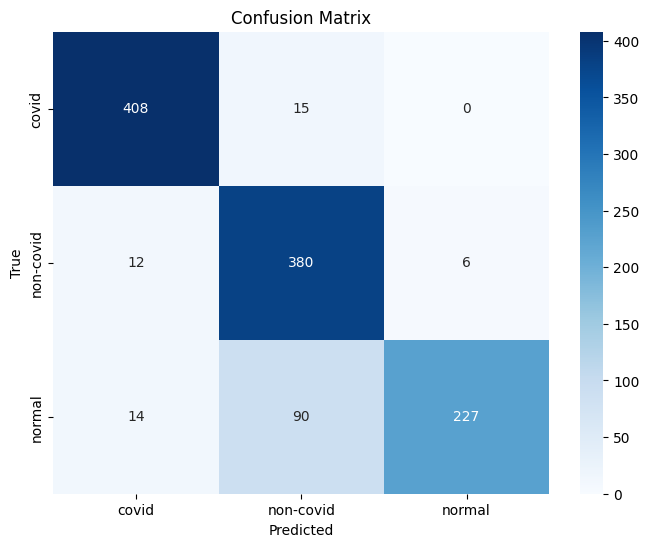

In [ ]:

# Evaluate the trained model on the test set

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute Evaluation Metrics and confusion matrix

test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

class_report = classification_report(all_labels, all_preds, target_names=['covid', 'non-covid', 'normal'])
print('Classification Report:')
print(class_report)

conf_matrix = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['covid', 'non-covid', 'normal'], yticklabels=['covid', 'non-covid', 'normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/resnext/resnext_only.pth')